# Comparison - Brand-level

## Helper Functions

In [ ]:
# Add 'Brand' variable
def extract_brand_from_title(title):
    """
    Calls OpenAI API to extract the real brand name from a product title.
    If no brand is confidently identified, returns 'Unknown'.
    """
    try:
        completion = openai.ChatCompletion.create(
            model="gpt-4o-mini",  # or use another model as needed
            messages=[
                {
                    "role": "system",
                    "content": (
                        "You are an expert at identifying real product brand names from product titles. "
                        "Only return the brand name if it is verifiably real. Do not invent or guess. "
                        "If you cannot determine a valid brand, return 'Unknown'."
                    )
                },
                {"role": "user", "content": title}
            ]
        )
        # Assuming the API returns the brand name in the plain text response.
        brand = completion.choices[0].message["content"].strip()
        return brand
    except Exception as e:
        print(f"Error processing title: {title}. Error: {e}")
        return "Unknown"

def clean_name(name):
    return str(name).lower().strip().replace("®", "").replace("™", "").replace("-", "").replace("’", "'").replace("é", "e")

# Replace brand names for consistency
def standardize_brand(df, brand_column="Brand"):
    """
    Standardizes brand names in the specified column of a DataFrame
    """
    df.loc[df[brand_column].str.contains("hill's", case=False, na=False), brand_column] = "hill's science diet"
    df.loc[df[brand_column].str.contains("wellness", case=False, na=False), brand_column] = "wellness"
    df.loc[df[brand_column].str.contains("purina", case=False, na=False), brand_column] = "purina"
    df.loc[df[brand_column].str.contains("fancy feast", case=False, na=False), brand_column] = "purina"
    df.loc[df[brand_column].str.contains("blue bottle", case=False, na=False), brand_column] = "blue bottle coffee"
    df.loc[df[brand_column].str.contains("canyon", case=False, na=False), brand_column] = "canyon coffee"
    df.loc[df[brand_column].str.contains("kloo", case=False, na=False), brand_column] = "kloo coffee"
    df.loc[df[brand_column].str.contains("king arthur", case=False, na=False), brand_column] = "king arthur baking company"
    return df

## Google Search versus Google Shopping versus LLM Websearch

### Preprocessing

In [ ]:
# googleshop0_df = pd.read_csv("GoogleShopping.csv")
# googlesearch0_df = pd.read_csv("GoogleSearch_Data_3_27.csv")

# # Add 'Brand' variable
# def extract_brand_from_title(title):
#     """
#     Calls OpenAI API to extract the real brand name from a product title.
#     If no brand is confidently identified, returns 'Unknown'.
#     """
#     try:
#         completion = openai.ChatCompletion.create(
#             model="gpt-4o-mini",  # or use another model as needed
#             messages=[
#                 {
#                     "role": "system",
#                     "content": (
#                         "You are an expert at identifying real product brand names from product titles. "
#                         "Only return the brand name if it is verifiably real. Do not invent or guess. "
#                         "If you cannot determine a valid brand, return 'Unknown'."
#                     )
#                 },
#                 {"role": "user", "content": title}
#             ]
#         )
#         # Assuming the API returns the brand name in the plain text response.
#         brand = completion.choices[0].message["content"].strip()
#         return brand
#     except Exception as e:
#         print(f"Error processing title: {title}. Error: {e}")
#         return "Unknown"

# Apply the extraction function to each Title.
# googleshop0_df["Brand"] = googleshop0_df["Title"].apply(extract_brand_from_title)
# googleshop0_df.to_csv("updated_googleshopping.csv", index=False)
# googlesearch0_df["Brand"] = googlesearch0_df["Product Title"].apply(extract_brand_from_title)
# googlesearch0_df.to_csv("updated_googlesearching.csv", index=False)

In [ ]:
# Load data
googlesearch_df = pd.read_csv("updated_googlesearching.csv")
llm_df = pd.read_csv("LLM_Websearch_Data_3_27.csv")
googleshop_df = pd.read_csv("updated_googleshopping.csv")

In [ ]:
def clean_name(name):
    return str(name).lower().strip().replace("®", "").replace("™", "").replace("-", "").replace("’", "'").replace("é", "e")

googlesearch_df["Brand"] = googlesearch_df["Brand"].map(clean_name)
llm_df["Brand"] = llm_df["Brand"].map(clean_name)
googleshop_df["Brand"] = googleshop_df["Brand"].map(clean_name)
llm_df["Title"] = llm_df["Title"].map(clean_name)

# Replace brand names for consistency
def standardize_brand(df, brand_column="Brand"):
    """
    Standardizes brand names in the specified column of a DataFrame
    """
    df.loc[df[brand_column].str.contains("hill's", case=False, na=False), brand_column] = "hill's science diet"
    df.loc[df[brand_column].str.contains("wellness", case=False, na=False), brand_column] = "wellness"
    df.loc[df[brand_column].str.contains("purina", case=False, na=False), brand_column] = "purina"
    df.loc[df[brand_column].str.contains("fancy feast", case=False, na=False), brand_column] = "purina"
    df.loc[df[brand_column].str.contains("blue bottle", case=False, na=False), brand_column] = "blue bottle coffee"
    df.loc[df[brand_column].str.contains("canyon", case=False, na=False), brand_column] = "canyon coffee"
    df.loc[df[brand_column].str.contains("kloo", case=False, na=False), brand_column] = "kloo coffee"
    df.loc[df[brand_column].str.contains("king arthur", case=False, na=False), brand_column] = "king arthur baking company"

    return df

googlesearch_df = standardize_brand(googlesearch_df, "Brand")
llm_df = standardize_brand(llm_df, "Brand")
googleshop_df = standardize_brand(googleshop_df, "Brand")

### Comparison

In [ ]:
def compare_brands(category, googlesearch_df, llm_df, googleshop_df):
    # Filter Google Search data by category.
    google_cat = googlesearch_df[googlesearch_df["Category"].str.lower() == category.lower()]
    google_brand_counts = google_cat["Brand"].str.lower().value_counts().reset_index()
    google_brand_counts.columns = ["brand", "count"]
    # Replace "unknown" with an approach-specific marker.
    google_brands = [("unknown_google" if b == "unknown" else b) for b in google_brand_counts["brand"].tolist()]
    google_set = set(google_brands)

    # Filter LLM WebSearch data by category.
    llm_cat = llm_df[llm_df["Product Title"].str.lower().str.contains(category.lower())]
    llm_brands = llm_cat["Brand"].str.lower().str.strip().tolist()
    # Replace "unknown" with an approach-specific marker.
    llm_brands = [("unknown_llm" if b == "unknown" else b) for b in llm_brands]
    llm_set = set(llm_brands)

    # Filter Google Shopping data by category.
    shop_cat = googleshop_df[googleshop_df["Product title"].str.lower() == category.lower()]
    shop_brand_counts = shop_cat["Brand"].str.lower().value_counts().reset_index()
    shop_brand_counts.columns = ["brand", "count"]
    shop_brands = [("unknown_shop" if b == "unknown" else b) for b in shop_brand_counts["brand"].tolist()]
    shop_set = set(shop_brands)

    # Compute intersections and differences.
    # Since "unknown" values have been replaced by approach-specific markers,
    # they will not be considered common.
    common_all = google_set & llm_set & shop_set
    common_google_llm = (google_set & llm_set) - shop_set
    common_google_shop = (google_set & shop_set) - llm_set
    common_llm_shop = (llm_set & shop_set) - google_set

    only_google = google_set - (llm_set | shop_set)
    only_llm = llm_set - (google_set | shop_set)
    only_shop = shop_set - (google_set | llm_set)

    # Print results if non-empty.
    print(f"\n📦 Category: {category.title()}")
    if common_all:
        print("✅ Common brands (all three):", sorted(common_all))
    if common_google_llm:
        print("🔹 Common in Google Search & LLM WebSearch:", sorted(common_google_llm))
    if common_google_shop:
        print("🔹 Common in Google Search & Google Shopping:", sorted(common_google_shop))
    if common_llm_shop:
        print("🔹 Common in LLM WebSearch & Google Shopping:", sorted(common_llm_shop))
    if only_google:
        print("🔸 Only in Google Search:", sorted(only_google))
    if only_llm:
        print("🔸 Only in LLM WebSearch:", sorted(only_llm))
    if only_shop:
        print("🔸 Only in Google Shopping:", sorted(only_shop))

    # Visualization using venn3.
    venn3([google_set, llm_set, shop_set],
          set_labels=("Google Search", "LLM WebSearch", "Google Shopping"))
    plt.title(f"Brand Overlap for {category.title()}")
    plt.show()



📦 Category: Dog Food
✅ Common brands (all three): ['purina']
🔹 Common in Google Search & LLM WebSearch: ['blue buffalo', "hill's science diet", 'merrick', 'orijen', 'royal canin', 'taste of the wild', 'wellness']
🔹 Common in Google Search & Google Shopping: ['cesar', 'pedigree']
🔸 Only in Google Search: ['annamaet pet foods', 'canidae', 'champion petfoods', 'freshpet', 'iams', 'instinct', 'mars petcare', 'nom nom', 'ollie', 'rachael ray', 'raw bistro', 'redbarn', "stella & chewy's", "the farmer's dog", 'viva', 'we feed raw']
🔸 Only in LLM WebSearch: ['nutro ultra', 'solid gold']
🔸 Only in Google Shopping: ['justfoodfordogs', "kibbles 'n bits", "ol' roy", 'open farm', 'simply nourish']


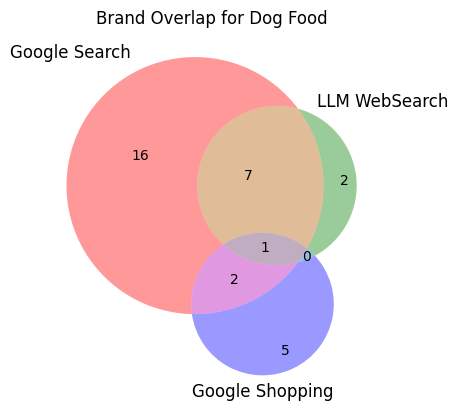


📦 Category: Cat Food
🔹 Common in Google Search & Google Shopping: ["hill's science diet", 'iams', 'meow mix', 'purina', 'sheba']
🔸 Only in Google Search: ['aatu', 'acana', 'blue buffalo', 'fancy feast', 'farmina', 'friskies', 'instinct', 'merrick', 'natural balance', 'nutrish', 'nutro', 'orijen', 'royal canin', 'taste of the wild', 'vital essentials', 'wellness']
🔸 Only in LLM WebSearch: ['bixbi', 'caru', 'open farm', 'rawr—eat like a lion', 'smalls', 'tcfeline', 'tiki cat', 'weruva', 'ziwi peak']
🔸 Only in Google Shopping: ['9lives', 'catit']


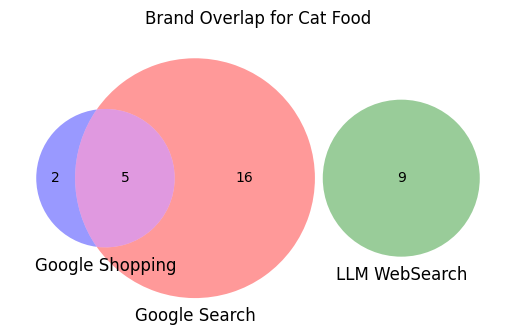


📦 Category: Cat Litter
✅ Common brands (all three): ['prettylitter', 'tidy cats']
🔹 Common in Google Search & LLM WebSearch: ["dr. elsey's", 'ever clean', 'fresh news', 'frisco', 'smartcat', 'tuft + paw', "world's best"]
🔹 Common in Google Search & Google Shopping: ['arm & hammer', 'fresh step', 'purina', "world's best cat litter"]
🔸 Only in Google Search: ['boxiecat', "cat's pride", 'catalyst', 'duranimals', 'iprimio', 'okocat', 'pidan', 'tuft & paw']
🔸 Only in LLM WebSearch: ['catalyst pet']
🔸 Only in Google Shopping: ['church & dwight company', 'paws & claws']


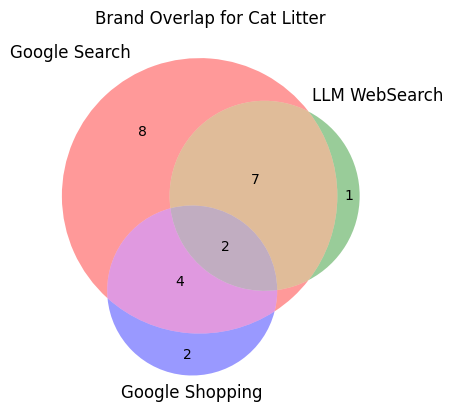


📦 Category: Instant Coffee
🔹 Common in Google Search & LLM WebSearch: ['blue bottle coffee', 'cafe grumpy', 'canyon coffee', 'kloo coffee', 'mount hagen', 'swift coffee', 'verve coffee roasters']
🔹 Common in Google Search & Google Shopping: ['cafe bustelo', 'folgers', 'maxwell house', 'nescafe']
🔸 Only in Google Search: ['alpine start', 'amazon', 'black rifle coffee company', 'brio coffeeworks', 'instacart', 'intelligentsia', 'juan valdez', 'kuju coffee', 'miir', 'no brand available', 'partners coffee', 'partners coffee roasters', 'pilon', 'saturnbird', 'starbucks', 'tandem coffee roasters', 'target', 'the dripkit', 'verve coffee', 'walmart']
🔸 Only in LLM WebSearch: ['sightglass']
🔸 Only in Google Shopping: ['bustelo', 'death wish coffee', 'unknown']


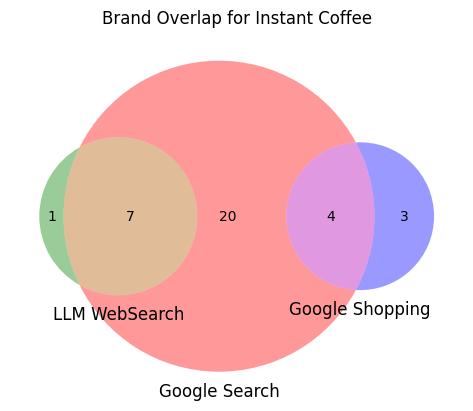


📦 Category: Baking Ingredients
✅ Common brands (all three): ["bob's red mill", 'king arthur baking company']
🔹 Common in LLM WebSearch & Google Shopping: ['mccormick']
🔸 Only in Google Search: ['antimo caputo', 'big spoon roasters', 'bona furtuna', "cook's", 'cultures for health', 'doughy', 'generic', 'hayden flour mills', 'kerrygold', 'luxardo', 'nestle', 'nielsenmassey', 'no review available', 'not specified', 'runamok', "see's candies", 'the loveless cafe', 'urban slicer pizza worx']
🔸 Only in LLM WebSearch: ['dawn foods', 'dr. oetker', 'ghirardelli', 'gold medal', 'hodgson mill', 'norma foods', 'valrhona']
🔸 Only in Google Shopping: ['arm & hammer', 'clabber girl', 'food to live', 'unknown']


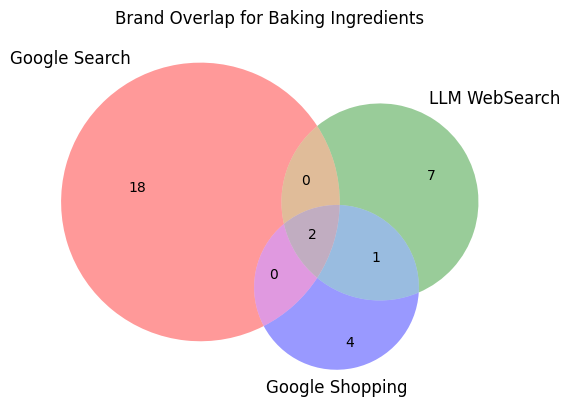

In [ ]:
# 3.25 data
compare_brands("dog food", googlesearch_df, llm_df, googleshop_df)
compare_brands("cat food", googlesearch_df, llm_df, googleshop_df)
compare_brands("cat litter", googlesearch_df, llm_df, googleshop_df)
compare_brands("instant coffee", googlesearch_df, llm_df, googleshop_df)
compare_brands("baking ingredients", googlesearch_df, llm_df, googleshop_df)


📦 Category: Dog Food
🔹 Common in Google Search & LLM WebSearch: ['acana', 'blue buffalo', "hill's science diet", 'merrick', 'nom nom', 'ollie', 'orijen', 'royal canin', "the farmer's dog", 'wellness']
🔹 Common in Google Search & Google Shopping: ['cesar', 'justfoodfordogs', "kibbles 'n bits", 'pedigree', 'purina']
🔸 Only in Google Search: ['annamaet', 'biljac', 'canidae', 'eukanuba', 'evermore', 'freshpet', 'fromm', 'iams', 'pawstruck', 'rachael ray nutrish', 'redbarn', 'taste of the wild', 'unknown_google', 'we feed raw']
🔸 Only in Google Shopping: ["ol' roy", 'open farm', 'simply nourish']


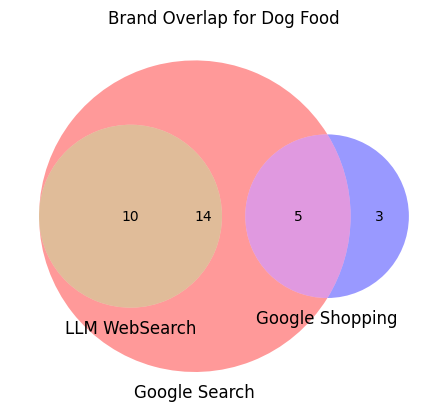


📦 Category: Cat Food
🔹 Common in Google Search & LLM WebSearch: ['open farm', 'smalls', 'tiki cat', 'wellness', 'weruva']
🔹 Common in Google Search & Google Shopping: ["hill's science diet", 'iams', 'meow mix', 'purina', 'sheba']
🔸 Only in Google Search: ['aatu', 'acana', 'aldi', 'almo nature', 'american journey', 'bixbi', 'blue buffalo', 'canidae', 'caru classics', 'merrick', "nature's logic", "nature's variety", 'philosophy', 'rachael ray', 'royal canin', 'taste of the wild', 'unknown_google', 'vital essentials']
🔸 Only in LLM WebSearch: ['caru classic', "dave's pet food", 'feline natural', 'ziwi peak']
🔸 Only in Google Shopping: ['9lives', 'catit']


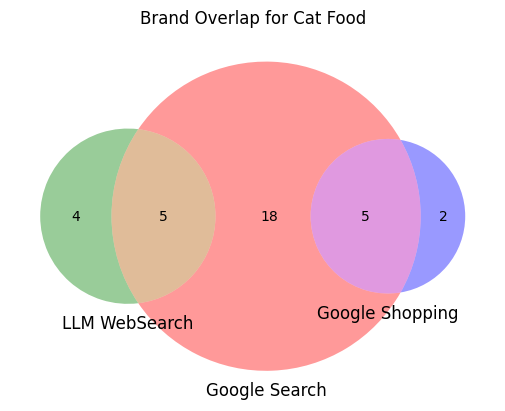


📦 Category: Cat Litter
✅ Common brands (all three): ['prettylitter', 'tidy cats']
🔹 Common in Google Search & LLM WebSearch: ["dr. elsey's", 'ever clean', 'frisco', 'smartcat', "world's best"]
🔹 Common in Google Search & Google Shopping: ['arm & hammer', 'fresh step', 'purina', "world's best cat litter"]
🔸 Only in Google Search: ['boxiecat', "cat's pride", 'catalyst', 'duranimals', 'iprimio', 'pretty litter', 'scoop away', 'tuft & paw', 'tuft + paw', 'unknown_google', 'ökocat']
🔸 Only in LLM WebSearch: ['catalyst pet', 'fresh news', 'tuft+paw']
🔸 Only in Google Shopping: ['church & dwight company', 'paws & claws']


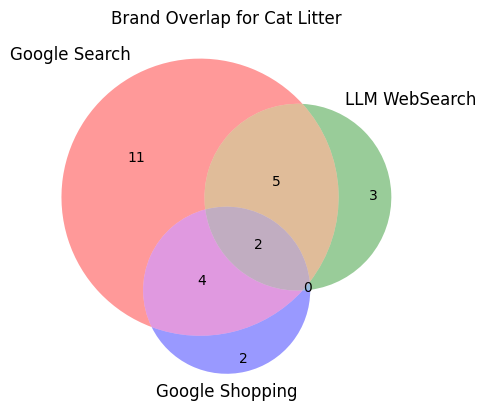


📦 Category: Instant Coffee
🔹 Common in Google Search & LLM WebSearch: ['intelligentsia', 'mount hagen', 'starbucks']
🔹 Common in Google Search & Google Shopping: ['cafe bustelo', 'folgers', 'maxwell house', 'nescafe']
🔸 Only in Google Search: ['alpine start', 'araku boomi', 'b&w', 'black rifle coffee company', 'cometeer', "dunkin'", 'four sigmatic', 'juan valdez', 'unknown_google', 'venture pal']
🔸 Only in LLM WebSearch: ['blue bottle coffee', 'cafe grumpy', 'canyon coffee', 'sightglass', 'swift coffee', 'verve coffee roasters']
🔸 Only in Google Shopping: ['bustelo', 'death wish coffee', 'unknown_shop']


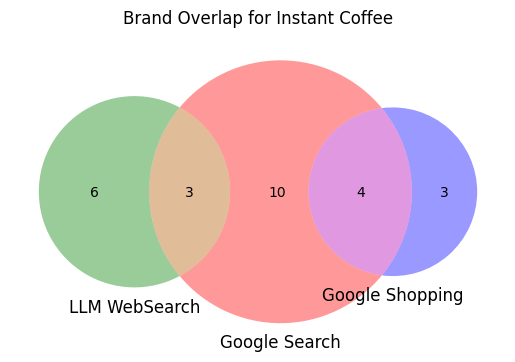


📦 Category: Baking Ingredients
🔹 Common in LLM WebSearch & Google Shopping: ["bob's red mill", 'king arthur baking company']
🔸 Only in Google Search: ['luxardo', 'maldon', 'unknown_google', 'valrhona']
🔸 Only in LLM WebSearch: ['domino', 'enjoy life', 'golden blossom', "libby's", 'quaker', 'red star', 'spectrum']
🔸 Only in Google Shopping: ['arm & hammer', 'clabber girl', 'food to live', 'mccormick', 'unknown_shop']


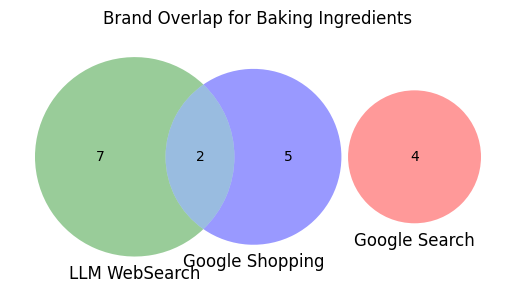

In [ ]:
# Updated 3.27 data
compare_brands("dog food", googlesearch_df, llm_df, googleshop_df)
compare_brands("cat food", googlesearch_df, llm_df, googleshop_df)
compare_brands("cat litter", googlesearch_df, llm_df, googleshop_df)
compare_brands("instant coffee", googlesearch_df, llm_df, googleshop_df)
compare_brands("baking ingredients", googlesearch_df, llm_df, googleshop_df)

### Trial

In [ ]:
google_dog = googlesearch_df[googlesearch_df["Category"] == "cat food"]

google_brand_counts = (
    google_dog["Brand"].value_counts()
    .reset_index()
    .rename(columns={"index": "brand", "Brand": "brand"})
)
google_brand_counts
google_brands = google_brand_counts["brand"].tolist()
google_brands
# # Obtain top 10 brands
# google_top10_brands = google_brand_counts.head(10)["count"].tolist()
# google_top10_brands

['purina',
 'iams',
 'natural balance',
 'blue buffalo',
 'royal canin',
 'sheba',
 'taste of the wild',
 'wellness',
 'nutro',
 "hill's science diet",
 'nutrish',
 'merrick',
 'instinct',
 'fancy feast',
 'meow mix',
 'vital essentials',
 'aatu',
 'acana',
 'farmina',
 'orijen',
 'friskies']

In [ ]:
llm_dog = llm_df[llm_df["Product Title"] == "cat food"]

# Take brands
llm_brands = (
    llm_dog["Brand"].tolist()
)
llm_brands

['smalls',
 'caru',
 'open farm',
 'weruva',
 'tiki cat',
 'tiki cat',
 'bixbi',
 'rawr—eat like a lion',
 'ziwi peak',
 'tcfeline']

## Nestle products

In [ ]:
# Add ranking info to llm_df
llm_df["LLM_Rank"] = llm_df.groupby("Product Title")["Product Title"].cumcount() + 1

# Apply cleaning to product titles
googlesearch_df["Product Title"] = googlesearch_df["Product Title"].map(clean_name)
llm_df["Product Title"] = llm_df["Product Title"].map(clean_name)

In [ ]:
# Add isNestle to llm_df
nestle_keywords = ["nestl", "purina", "nescaf", "toll"]
llm_df["isNestle"] = llm_df["Brand"].str.lower().apply(lambda x: int(any(k in x for k in nestle_keywords)))

In [ ]:
# google_df["isNestle"] = google_df["Brand"].str.lower().apply(lambda x: int(any(k in x for k in nestle_keywords)))

def standardize_clean_name(name):
    name = str(name).lower()
    if "fancy feast" in name:
        return "purina fancy feast"
    elif "friskies" in name:
        return "purina friskies"
    elif "purina one" in name:
        return "purina one"
    elif "pro plan" in name:
        return "purina pro plan"
    elif "purina" in name:
        return "purina"
    else:
        return name

llm_df["clean_name"] = llm_df["Title"].apply(standardize_clean_name)
google_df["clean_name"] = google_df["Product Title"].apply(standardize_clean_name)

In [ ]:
google_nestle = google_df[google_df["isNestle"] == 1]

google_summary = (
    google_nestle.groupby("clean_name")
    .agg(
        google_avg_rank=("Result Rank", "mean"),
        website_count=("Source Link", "nunique")
    )
    .reset_index()
)

llm_nestle = llm_df[llm_df["isNestle"] == 1][["clean_name", "LLM_Rank"]]

comparison = pd.merge(google_summary, llm_nestle, on="clean_name", how="outer")
comparison

,clean_name,google_avg_rank,website_count,LLM_Rank
0,nescafé taster's choice,5.000000,1,NaN
1,nestle toll house baking chips,3.000000,1,NaN
2,purina,4.800000,5,NaN
3,purina fancy feast,3.666667,1,NaN
4,purina friskies,10.000000,1,NaN
5,purina one,5.500000,3,NaN
6,purina pro plan,6.200000,4,7.0


In [ ]:
google_df.head()

,Result Rank,Product Title,Comment,Brand,Source Link,Source Rank,isNestle,isTop3Nestle,hasNestleInLink,Query,Timestamp,Category,clean_name
0,1,Blue Buffalo Life Protection Formula,"Highly regarded for its natural ingredients, B...",Blue Buffalo,https://www.petmd.com/dog/vet-verified/best-do...,1,0,0,1,Best dog food,2025-03-18 23:39,dog food,blue buffalo life protection formula
1,2,Wellness CORE Grain-Free,Many pet owners appreciate the grain-free form...,Wellness,https://www.petmd.com/dog/vet-verified/best-do...,1,0,0,1,Best dog food,2025-03-18 23:39,dog food,wellness core grainfree
2,3,Merrick Grain-Free Texas Beef and Sweet Potato,Merrick is praised for using high-quality ingr...,Merrick,https://www.petmd.com/dog/vet-verified/best-do...,1,0,0,1,Best dog food,2025-03-18 23:39,dog food,merrick grainfree texas beef and sweet potato
3,4,Taste of the Wild High Prairie Canine Recipe,This dog food is popular for its unique protei...,Taste of the Wild,https://www.petmd.com/dog/vet-verified/best-do...,1,0,0,1,Best dog food,2025-03-18 23:39,dog food,taste of the wild high prairie canine recipe
4,5,Royal Canin Size Health Nutrition Medium Adult...,Royal Canin is known for its breed-specific fo...,Royal Canin,https://www.petmd.com/dog/vet-verified/best-do...,1,0,0,1,Best dog food,2025-03-18 23:39,dog food,royal canin size health nutrition medium adult...
